# Classificatiemodel

In [ ]:
# from datetime import datetime
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import pyodbc
import sqlalchemy
import matplotlib.pyplot as plt

# Data inlezen en kolommen selecteren

In [ ]:
DB = {'servername': 'ENVY-AKRAM\\SQLEXPRESS','database': 'Great Outdoors - Akram en Sylvan'}
conn_str = ('DRIVER={ODBC Driver 17 for SQL Server};SERVER=' + DB['servername'] + ';DATABASE=' + DB['database'] + ';Trusted_Connection=yes')
export_conn = pyodbc.connect(conn_str, timeout=120)
export_cursor = export_conn.cursor()

engine = sqlalchemy.create_engine(f"mssql+pyodbc:///?odbc_connect={conn_str}")

print(export_cursor.execute("SELECT @@version;"))
export_cursor

In [ ]:
order_dw = pd.read_sql_query("SELECT * FROM [Order]", engine)
order_dw

In [ ]:
returned_item_dw = pd.read_sql_query("SELECT * FROM Returned_item", engine)
returned_item_dw

In [ ]:
order_method_dw = pd.read_sql_query("SELECT * FROM Order_method", engine)
order_method_dw

In [148]:
datasetClassProduct = pd.merge(
    order_dw[['PRODUCT_NUMBER', 'ORDER_METHOD_CODE','ORDER_DETAIL_CODE', 'QUANTITY', 'UNIT_COST', 'ORDER_DATE']],
    order_method_dw[['ORDER_METHOD_CODE', 'ORDER_METHOD_EN']], on='ORDER_METHOD_CODE', how='inner'
).merge(
    returned_item_dw[['ORDER_DETAIL_CODE', 'RETURN_REASON_CODE'
                      #, 'RETURN_DATE'
                      ]], on='ORDER_DETAIL_CODE', how='inner'
)

#datasetClassProduct['RETURN_REASON_CODE'] = datasetClassProduct['RETURN_REASON_CODE'].fillna('n.v.t.')
datasetClassProduct


,PRODUCT_NUMBER,ORDER_METHOD_CODE,ORDER_DETAIL_CODE,QUANTITY,UNIT_COST,ORDER_DATE,ORDER_METHOD_EN,RETURN_REASON_CODE
0,70,5,48120,24,81.8,2020-09-28,Web,2
1,4,7,47767,84,5.23,2020-03-14,Sales visit,2
2,63,2,48073,68,32.59,2020-04-04,Telephone,2
3,65,4,49029,40,39,2021-03-26,E-mail,1
4,29,7,48713,152,41.77,2021-03-29,Sales visit,4
...,...,...,...,...,...,...,...,...
701,36,4,110685,90,18.05,2022-12-10,E-mail,5
702,93,2,109838,90,1.79,2020-07-14,Telephone,1
703,15,2,110540,24,490,2022-08-05,Telephone,5
704,40,2,110112,80,18.19,2021-01-18,Telephone,3


In [149]:
#helperfunctie

def ToProductAge(date_str):
    date_obj = pd.to_datetime(date_str, dayfirst=True)
    return (datetime.now() - date_obj).days


In [150]:
methodDummies = pd.get_dummies(datasetClassProduct['ORDER_METHOD_EN'])
datasetClassProduct = pd.concat([datasetClassProduct, methodDummies], axis=1)
datasetClassProduct.drop('ORDER_METHOD_EN', axis=1, inplace=True)

productDummies = pd.get_dummies(datasetClassProduct['PRODUCT_NUMBER'])
datasetClassProduct = pd.concat([datasetClassProduct, productDummies], axis=1)
datasetClassProduct.drop('PRODUCT_NUMBER', axis=1, inplace=True)


datasetClassProduct['DAYS_SINCE_ORDER'] = datasetClassProduct['ORDER_DATE'].apply(ToProductAge)
datasetClassProduct.drop('ORDER_DATE', axis=1, inplace=True)

#datasetClassProduct['DAYS_SINCE_RETURN'] = datasetClassProduct['RETURN_DATE'].apply(ToProductAge)
#datasetClassProduct.drop('RETURN_DATE', axis=1, inplace=True)

datasetClassProduct.drop('ORDER_METHOD_CODE', axis=1, inplace=True)
datasetClassProduct.drop('ORDER_DETAIL_CODE', axis=1, inplace=True)


datasetClassProduct

C:\Users\akram\AppData\Local\Temp\ipykernel_25948\4180136989.py:4: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  date_obj = pd.to_datetime(date_str, dayfirst=True)


,QUANTITY,UNIT_COST,RETURN_REASON_CODE,E-mail,Fax,Mail,Sales visit,Special,Telephone,Web,...,91,92,93,94,95,96,97,98,99,DAYS_SINCE_ORDER
0,24,81.8,2,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,1298
1,84,5.23,2,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,1496
2,68,32.59,2,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,1475
3,40,39,1,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1119
4,152,41.77,4,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,1116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
701,90,18.05,5,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,554
702,90,1.79,1,False,False,False,False,False,True,False,...,False,False,True,False,False,False,False,False,False,1374
703,24,490,5,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,711
704,80,18.19,3,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,1186


In [151]:
x = datasetClassProduct.drop('RETURN_REASON_CODE', axis = 1)
y = datasetClassProduct.loc[:,['RETURN_REASON_CODE']]
y

,RETURN_REASON_CODE
0,2
1,2
2,2
3,1
4,4
...,...
701,5
702,1
703,5
704,3


In [152]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, 
    test_size=0.15, random_state=42
)
y_train


,RETURN_REASON_CODE
44,5
398,2
70,2
164,4
289,5
...,...
71,5
106,1
270,4
435,3


In [153]:
list(x.columns)

['QUANTITY',
 'UNIT_COST',
 'E-mail',
 'Fax',
 'Mail',
 'Sales visit',
 'Special',
 'Telephone',
 'Web',
 '1',
 '10',
 '101',
 '102',
 '103',
 '104',
 '105',
 '107',
 '108',
 '109',
 '11',
 '110',
 '111',
 '112',
 '113',
 '114',
 '115',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '2',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '3',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '4',
 '40',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46',
 '47',
 '49',
 '5',
 '50',
 '51',
 '52',
 '53',
 '54',
 '55',
 '56',
 '57',
 '58',
 '59',
 '6',
 '60',
 '61',
 '62',
 '63',
 '64',
 '65',
 '66',
 '67',
 '68',
 '69',
 '7',
 '70',
 '71',
 '72',
 '73',
 '74',
 '75',
 '76',
 '77',
 '78',
 '79',
 '8',
 '80',
 '81',
 '82',
 '83',
 '84',
 '85',
 '86',
 '87',
 '88',
 '89',
 '9',
 '90',
 '91',
 '92',
 '93',
 '94',
 '95',
 '96',
 '97',
 '98',
 '99',
 'DAYS_SINCE_ORDER']

# Decision Tree bouwen en evalueren 

Max_depth = 2

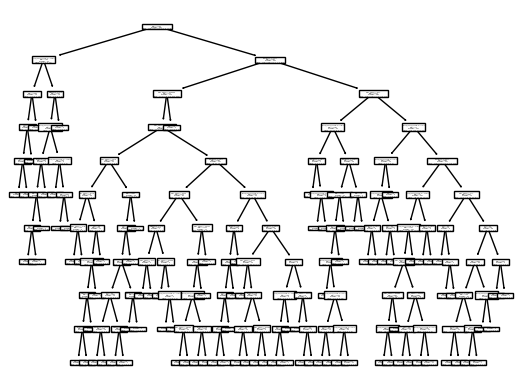

In [174]:
dtree = DecisionTreeClassifier(max_depth = 10)
dtree = dtree.fit(x_train, y_train)
tree.plot_tree(dtree, feature_names = x.columns)
plt.show()

In [176]:
df_predicted = pd.DataFrame(dtree.predict(x_test))
df_predicted = df_predicted.rename(columns = {0: 'Predicted_Returned'})
resultaat_model = pd.concat([y_test.reset_index()['RETURN_REASON_CODE'], df_predicted], axis = 1)
resultaat_model

,RETURN_REASON_CODE,Predicted_Returned
0,5,1
1,1,1
2,1,1
3,1,2
4,5,5
...,...,...
101,5,2
102,1,2
103,5,1
104,1,1


In [177]:
counts = df_predicted['Predicted_Returned'].value_counts()
counts

Predicted_Returned
1    62
2    24
5    14
3     4
4     2
Name: count, dtype: int64

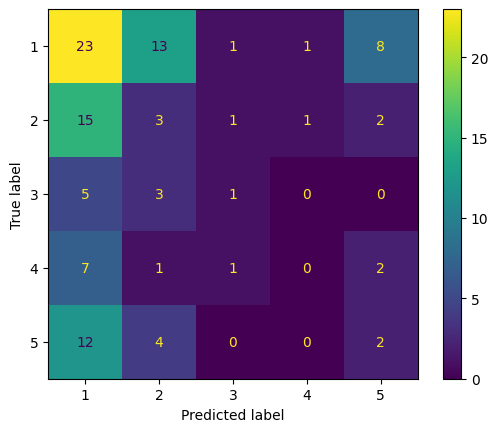

In [178]:
cf_matrix = metrics.confusion_matrix(resultaat_model['RETURN_REASON_CODE'], resultaat_model['Predicted_Returned'])
cf_matrix_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cf_matrix, display_labels = [1, 2, 3, 4, 5])

cf_matrix_display.plot()
plt.show()

In [179]:
metrics.accuracy_score(resultaat_model['RETURN_REASON_CODE'], resultaat_model['Predicted_Returned'])

0.27358490566037735